# Exersice 4.2 (Solution)
## QAP & MRQAP
---

In this exercise you will compute correlations between two networks, and measure significance using permutation test.\
You will work with `directed graphs` as dataframe of edgelists, as well as adjacency matrices as numpy arrays.\
Given the data, *'a social network of the managers of a high-tech company'*, you will learn how to create three types of hypotheses:\
dyadic, mixed monadic-dyadic, and node-level.\
\
At the end of this task, you will know how to interpret regression results as well as the significance from permutation tests.

1. Load the Krackhardt dataset (get to know the data!).
 - Compare data description file with actual data.


2. Practice QAP with dyadic hypotheses.
 - Create dyad-level hypotheses.
 - Run a correlation test between two variables, and check its significance using permutation test!


3. Practice MRQAP with dyadic hypotheses.
 - Create dyad-level hypotheses.
 - Build a linear regression model, and check the significance of each ind. variable using permutation test!


4. Practice QAP with mixed monadic-dyadic hypotheses.
 - Create monadic-level and dyad-level hypotheses.
 - Run a correlation test between two variables, and check its significance using permutation test!


5. Practice MRQAP with mixed monadic-dyadic hypotheses.
 - Create monadic-level and dyad-level hypotheses.
 - Build a linear regression model, and check the significance of each ind. variable using permutation test!


6. Practice MRQAP with node-level hypotheses.
 - Create node-level (node structure, node attribute) hypotheses.
 - Build a linear regression model, and check the significance of each ind. variable using permutation test!
 

---
## QUIZ
*Get to know the data from the '**description file**'!*\
Open the file `data/krackhardt/README.md` and read the description of this dataset.

 
- What type of network do we have? monolayer or multilayer?
- Is the network directed or undirected?
- How many layers? nodes? and total edges?

---
## Task #1
#### Load the data!
Load the multilayer network, and nodes' metadata.

---

#### Dependencies (libraries)
Import here all necessary python packages

In [1]:
#### Dependencies
import pandas as pd

In [2]:
#### Local dependencies
# %load_ext autoreload
# %autoreload 2
    
import sys
sys.path.append('../libs/')

from qap import QAP
from mrqap import MRQAP
import helper

#### Loading network
The datasets for this exercise are in `data/krackhardt/`.

Load nodes' metadata, and store in `nodes` the node ids.

In [3]:
# read file containing node attributes
nodes_metadata = pd.read_csv("../../data/krackhardt/Krackhardt-High-Tech_nodes.txt", index_col=None, header=0, sep=' ')
nodes_metadata.head()

,nodeID,nodeAge,nodeTenure,nodeLevel,nodeDepartment
0,1,33,9,3,4
1,2,42,20,2,4
2,3,40,13,3,2
3,4,33,8,3,4
4,5,32,3,3,2


In [4]:
nodes = nodes_metadata.nodeID

Load the *Krackhardt* multilayer network as a DataFrame, and rename columns accordingly (source, target, layer weight).\
**HINT**: *Check the 'description file' to know what the format of the file is (what each column represent)*

In [5]:
# read file containing multilayer network
df_edges = pd.read_csv("../../data/krackhardt/Krackhardt-High-Tech_multiplex.edges", index_col=None, header=None, sep=' ')
df_edges.rename(columns={0:'layer', 1:'source', 2:'target', 3:'weight'}, inplace=True) # inplace = True, so the 
                                                                                       # changes are effective 
                                                                                       # in the same DataFrame
df_edges.head()

,layer,source,target,weight
0,1,1,2,1
1,1,1,4,1
2,1,1,8,1
3,1,1,16,1
4,1,1,18,1


Load layers' metadata (labels).\
*HINT: The multilayer you just loaded identifies each layer as 1,2,3. But what are those numbers? Let's understand these layers.*

In [6]:
# read file containing layer metadata (labels)
layers = pd.read_csv('../../data/krackhardt/Krackhardt-High-Tech_layers.txt', index_col=None, header=0, sep=' ')
layers

,layerID,layerLabel
0,1,advice
1,2,friendship
2,3,Reports_to


---
## QUIZ
*Get to know your data from a DataFrame.*\
Using the DataFrames you loaded before, write the necessary code to answer the following questions:
1. How many edges does this network have?
2. How many unique nodes?
3. How many layers?
4. What is the sum of edge-weights per layer?

Are these numbers matching the numbers reported in the *description file*?\
\
*HINT 1: You can ask for the `shape` of the DataFrame containing the edges (remember, it has rows referring to each edge) and columns (edge-attributes)*\
*HINT 2: You can ask for the `shape` of the DataFrame containing the nodes (remember, it has rows referring to each node) and columns (node-attributes)*\
*HINT 3: The DataFrame containing the edges posses a column referring to the layer id (you actually gave it a particular name). Is there a function in pandas to get the number of unique values from a column? (you can ask Google).*\
*HINT 4: What about using a `groupby` in the DataFrame containing the edges? What should you group-by then? After grouping by, which function should you call to get the summation over the edge weights?*

In [7]:
# number of edges
m = df_edges.shape[0]
print('Number of edges: {}'.format(m))

# number of nodes
n = df_edges.source.append(df_edges.target).nunique() # alternative 1: through the edges
#n = nodes.shape[0]                                    # alternative 2: through the node-metadata DataFrame
print('Number of nodes: {}'.format(n))

# number of layers
l = df_edges.layer.nunique()
print('Number of layers: {}'.format(l))

# sum of weights per layer, and overall
sewl = df_edges.groupby('layer')['weight'].sum()
print('Sum of all edge-weights: {}'.format(sewl.sum()))
print('\nSum of edge-weights per layer:\n {}'.format(sewl))

Number of edges: 312
Number of nodes: 21
Number of layers: 3
Sum of all edge-weights: 312

Sum of edge-weights per layer:
 layer
1    190
2    102
3     20
Name: weight, dtype: int64


---
## Task #2
#### Practice QAP with dyadic hypotheses.

Find the correlation between two of the available variables (layers).\
How significant is this value?\
How would you interpret this result?

---

#### Adjacency matrices
Extract each layer separately from the multilayer DataFrame.\
\
*HINT 1: Are the networks directed or undirected? Chech it out in the 'description' file.*\
*HINT 2: You need the adjacency matrices of each layer. So, you can either use one of the methods we learnt on Monday on how to convert pandas edgelist to networkx graph, and then to adjacency matrix, or you can simply use the helper function `get_adjacency_from_pandas_weighted_edgelist(...)` from the `helper` library (see the demo notebook).*

In [8]:
# Advice (layer=1)
tmp = df_edges.query("layer == 1")[['source','target','weight']]
A = helper.get_adjacency_from_pandas_weighted_edgelist(df=tmp,
                                                       nodes_order=nodes,
                                                       directed=True)

A.shape, A.min(), A.max(), A.sum()

((21, 21), 0, 1, 190)

In [9]:
# Let's check how the adjacency matrix looks like.
A

array([[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [10]:
# Friendship (layer=2)
tmp = df_edges.query("layer == 2")[['source','target','weight']]
F = helper.get_adjacency_from_pandas_weighted_edgelist(df=tmp,
                                                       nodes_order=nodes,
                                                       directed=True)
F.shape, F.min(), F.max(), F.sum()

((21, 21), 0, 1, 102)

#### QAP: advice vs. friendship

In [11]:
# Run QAP
qap_obj = QAP(Y=A, X=F, npermutations=5000, seed=12345)
qap_obj.qap()
qap_obj.summary()

[2020-09-24 20:35:14] Observed Pearson's correlation: 0.1546
[2020-09-24 20:35:16] 
[2020-09-24 20:35:16] # Permutations: 5000
[2020-09-24 20:35:16] Duration (sec.): 2
[2020-09-24 20:35:16] 
[2020-09-24 20:35:16] - Sum all betas: 1.5585909999999723
[2020-09-24 20:35:16] - Min betas: -0.235862
[2020-09-24 20:35:16] - Max betas: 0.266142
[2020-09-24 20:35:16] - Average betas: 0.00031171819999999866
[2020-09-24 20:35:16] - Std. Dev. betas: 0.07201095813288967
[2020-09-24 20:35:16] 
[2020-09-24 20:35:16] prop >= 0.1546: 0.0112 P(Large)
[2020-09-24 20:35:16] prop <= 0.1546: 0.9888 P(Small)


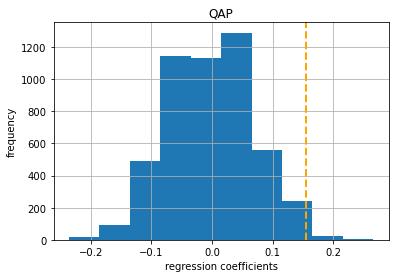

In [12]:
# Plot distribution of correlation scores (permutation test)
qap_obj.plot()

---
# Task 3
#### Practice MRQAP with dyadic hypotheses.
Your dependent variable is 'Advice'.\
How significant are the regression coefficients (for friendship and report) with respect to the dependent variable?\
How would you interpret these results?\
\
*HINT 1: Get the adjacency matrix of the layer 'reports_to'*\
*HINT 2: What is Y? and What is X?*

---

In [13]:
# Report (layer=3)
tmp = df_edges.query("layer == 3")[['source','target','weight']]
R = helper.get_adjacency_from_pandas_weighted_edgelist(df=tmp,
                                                       nodes_order=nodes,
                                                       directed=True)
R.shape, R.min(), R.max(), R.sum()

((21, 21), 0, 1, 20)

In [14]:
# MRQAP
Y = {'advice':A}
X = {'friendship':F, 'report':R}
mrqap_obj = MRQAP(Y=Y, X=X, npermutations=5000, standarized=True, seed=12345)
mrqap_obj.mrqap()

In [15]:
# Print MRQAP summary
mrqap_obj.summary()


                         advice ~ friendship + report                         
   R-Square  Adj. R-Sqr.   Obs.  Perms.  Duration (sec.)
0    0.0632       0.0587  420.0    5000               93

                           Summary Permutation Test                           

               MIN     MAX  MEDIAN    MEAN     STD    BETA    P(+)    P(-)
Intercept        0       0       0       0       0       0       0       1
friendship -0.2557  0.2629 -0.0014 -0.0008  0.0729   0.117  0.0536  0.9464
report     -0.1658  0.1836 -0.0008       0  0.0544  0.2018       0       1


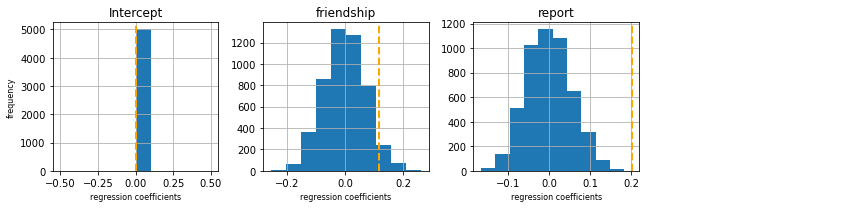

In [16]:
# Plot distribution of coefficients (permutation test)
mrqap_obj.plot()

---
# Task 4
#### Practice QAP with mixed dyadic-monadic hypotheses.

*Hypothesis:*\
*People tend to **report** to people who are **older** than themselves.*

Find the correlation between 'reports' (dyad) and 'difference in age' (monadic) variables between people.\
How significant is this value?\
How would you interpret this result?\
\
*HINT 1: Use `helper.get_monadic_hypothesis` to obtain a node-by-node matrix using the `nodeAge` attribute.*\
*HINT 2: If 'source' node reports to 'target' node, that means that (according to the hypothesis) 'target' must be older than 'source'.*\
*HINT 3: Your 'comparison_function' must give higher scores to cases when 'age_target > age_source'.*\
*HINT 4: What about doing a substraction? `age_target - age_source`? or `age_source - age_target`?*

---

In [17]:
# Create monadic-hypothesis (target is older than source)
O = helper.get_monadic_hypothesis(nodes_metadata, 
                                  keyid='nodeID', 
                                  attribute='nodeAge', 
                                  comparison_fnc=helper.compare_subs_target_source, 
                                  symmetric=False,
                                  keyorder=nodes)

O.shape, O.min(), O.max(), O.sum()

((21, 21), -35.0, 35.0, 0.0)

In [18]:
# Let's check how the monadic matrix looks like.
pd.DataFrame(O).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,9.0,7.0,0.0,-1.0,26.0,22.0,1.0,29.0,4.0,...,1.0,15.0,10.0,7.0,-6.0,-3.0,0.0,-1.0,5.0,3.0
1,-9.0,0.0,-2.0,-9.0,-10.0,17.0,13.0,-8.0,20.0,-5.0,...,-8.0,6.0,1.0,-2.0,-15.0,-12.0,-9.0,-10.0,-4.0,-6.0
2,-7.0,2.0,0.0,-7.0,-8.0,19.0,15.0,-6.0,22.0,-3.0,...,-6.0,8.0,3.0,0.0,-13.0,-10.0,-7.0,-8.0,-2.0,-4.0
3,0.0,9.0,7.0,0.0,-1.0,26.0,22.0,1.0,29.0,4.0,...,1.0,15.0,10.0,7.0,-6.0,-3.0,0.0,-1.0,5.0,3.0
4,1.0,10.0,8.0,1.0,0.0,27.0,23.0,2.0,30.0,5.0,...,2.0,16.0,11.0,8.0,-5.0,-2.0,1.0,0.0,6.0,4.0


In [19]:
# Run QAP
qap_obj = QAP(Y=R, X=O, npermutations=5000, seed=12345)
qap_obj.qap()
qap_obj.summary()

[2020-09-24 20:36:51] Observed Pearson's correlation: 0.0645
[2020-09-24 20:36:52] 
[2020-09-24 20:36:52] # Permutations: 5000
[2020-09-24 20:36:52] Duration (sec.): 2
[2020-09-24 20:36:52] 
[2020-09-24 20:36:52] - Sum all betas: -6.554809999999995
[2020-09-24 20:36:52] - Min betas: -0.16629
[2020-09-24 20:36:52] - Max betas: 0.249849
[2020-09-24 20:36:52] - Average betas: -0.0013109620000000004
[2020-09-24 20:36:52] - Std. Dev. betas: 0.07081024792754899
[2020-09-24 20:36:52] 
[2020-09-24 20:36:52] prop >= 0.0645: 0.183 P(Large)
[2020-09-24 20:36:52] prop <= 0.0645: 0.817 P(Small)


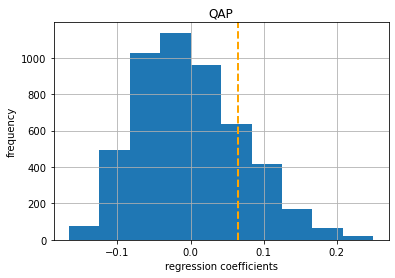

In [20]:
# Plot distribution of correlation scores (permutation test)
qap_obj.plot()

---
# Task 5
#### Practice MRQAP with mixed dyadic-monadic hypotheses.

*Hypothesis:*\
*People (regardless of their age) are more likely to **report** to **older people** who belong to the **same department** and are in **different levels** of hierarchy.*\
\
*HINT 1: Be careful! The monadic hypothesis related to 'nodeAge' in this task is different from the one in task 4.*\
*HINT 2: You just need to use another 'comparison_function'. What about `compare_target_value`?*

---

In [21]:
# Create monadic-hypothesis (the older the target node/person, the more likely to get reports from source node-person)
P = helper.get_monadic_hypothesis(nodes_metadata, 
                                  keyid='nodeID', 
                                  attribute='nodeAge', 
                                  comparison_fnc=helper.compare_target_value, 
                                  symmetric=False,
                                  keyorder=nodes)

P.shape, P.min(), P.max(), P.sum()

((21, 21), 0.0, 62.0, 16680.0)

In [22]:
# Let's check how the monadic matrix looks like.
pd.DataFrame(P).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,42.0,40.0,33.0,32.0,59.0,55.0,34.0,62.0,37.0,...,34.0,48.0,43.0,40.0,27.0,30.0,33.0,32.0,38.0,36.0
1,33.0,0.0,40.0,33.0,32.0,59.0,55.0,34.0,62.0,37.0,...,34.0,48.0,43.0,40.0,27.0,30.0,33.0,32.0,38.0,36.0
2,33.0,42.0,0.0,33.0,32.0,59.0,55.0,34.0,62.0,37.0,...,34.0,48.0,43.0,40.0,27.0,30.0,33.0,32.0,38.0,36.0
3,33.0,42.0,40.0,0.0,32.0,59.0,55.0,34.0,62.0,37.0,...,34.0,48.0,43.0,40.0,27.0,30.0,33.0,32.0,38.0,36.0
4,33.0,42.0,40.0,33.0,0.0,59.0,55.0,34.0,62.0,37.0,...,34.0,48.0,43.0,40.0,27.0,30.0,33.0,32.0,38.0,36.0


In [23]:
# Create monadic-hypothesis (same department)
D = helper.get_monadic_hypothesis(nodes_metadata, 
                                  keyid='nodeID', 
                                  attribute='nodeDepartment', 
                                  comparison_fnc=helper.compare_same, 
                                  symmetric=True,
                                  keyorder=nodes)

D.shape, D.min(), D.max(), D.sum()

((21, 21), 0.0, 1.0, 94.0)

In [24]:
# Create monadic-hypothesis (different level)
L = helper.get_monadic_hypothesis(nodes_metadata, 
                                  keyid='nodeID', 
                                  attribute='nodeLevel', 
                                  comparison_fnc=helper.compare_different, 
                                  symmetric=True,
                                  keyorder=nodes)

L.shape, L.min(), L.max(), L.sum()

((21, 21), 0.0, 1.0, 168.0)

In [25]:
# Run MRQAP
Y = {'ADV':A}
X = {'AGE':P, 'SAME_DEP':D, 'DIFF_LEV':L}
mrqap_obj = MRQAP(Y=Y, X=X, npermutations=5000, standarized=True, seed=12345)
mrqap_obj.mrqap()

In [26]:
# Print summary of MRQAP
mrqap_obj.summary()


                       ADV ~ AGE + SAME_DEP + DIFF_LEV                        
   R-Square  Adj. R-Sqr.   Obs.  Perms.  Duration (sec.)
0    0.0124       0.0052  420.0    5000              108

                           Summary Permutation Test                           

              MIN     MAX  MEDIAN    MEAN     STD    BETA    P(+)    P(-)
Intercept       0       0       0       0       0       0       0       1
AGE       -0.2506  0.2988 -0.0045 -0.0016    0.09 -0.0261  0.5936  0.4064
SAME_DEP  -0.1812  0.1756  0.0006  0.0007  0.0517   0.047  0.1834  0.8166
DIFF_LEV  -0.2335  0.2714 -0.0045 -0.0004  0.0766   0.103  0.1034  0.8966


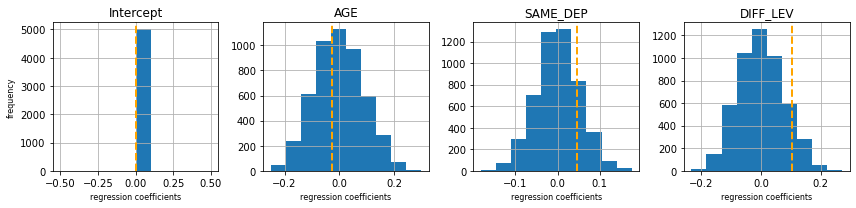

In [27]:
# Plot distribution of coefficients (permutation test)
mrqap_obj.plot()

---
# Task 6
#### Practice MRQAP with node-level hypotheses.

*Hypothesis:*\
*People's **PageRank** in the **reports_to** network can be explained by **tenure** and **level**.*\
\
*HINT 1: Recall that PageRank measures importance of nodes in a network. This is a node-structure property.*\
*HINT 2: Check in `code/libs/helper.py` if there is a function for `ego` that computes `pagerank`.*\
*HINT 3: We are testing a node-level hypothesis. What is the new parameter that `MRQAP` needs?*\
*HINT 4: Where did you store the node-attributes? Check task 1.*

What is your guess? How significant results will be?

---

In [28]:
# Create node-level (structural) hypothesis: PageRank of node
PR = helper.get_ego_hypothesis(adjacency=R, 
                               ego_fnc=helper.ego_pagerank,
                               missing=0)

PR.shape, PR.min(), PR.max(), PR.sum(), PR

((21,),
 0.020177562550443905,
 0.3220338983050847,
 1.0,
 array([0.02017756, 0.07163035, 0.02017756, 0.02017756, 0.02017756,
        0.02017756, 0.3220339 , 0.02017756, 0.02017756, 0.02017756,
        0.02017756, 0.02017756, 0.02017756, 0.14023406, 0.02017756,
        0.02017756, 0.02017756, 0.05447942, 0.02017756, 0.02017756,
        0.08878128]))

In [29]:
# Create node-level (attribute) hypothesis: tenure
T = nodes_metadata.nodeTenure.values
T.shape, T.min(), T.max(), T.sum(), T

((21,),
 0,
 30,
 246,
 array([ 9, 20, 13,  8,  3, 28, 30, 11,  5,  9, 27,  9,  0, 10,  8,  5, 12,
         9,  5, 12, 13]))

In [30]:
# Create node-level (attribute) hypothesis: level
V = nodes_metadata.nodeLevel.values
V.shape, V.min(), V.max(), V.sum()

((21,), 1, 3, 57)

In [31]:
# Run MRQAP
Y = {'pagerank':PR}
X = {'tenure':T, 'level':V}
mrqap_obj = MRQAP(Y=Y, X=X, node_regression=True, standarized=True, npermutations=2000, seed=12345)
mrqap_obj.mrqap()

In [32]:
# Print MRQAP summary 
mrqap_obj.summary()


                          pagerank ~ tenure + level                           
   R-Square  Adj. R-Sqr.  Obs.  Perms.  Duration (sec.)
0    0.8331       0.8135  20.0    2000               35

                           Summary Permutation Test                           

              MIN     MAX  MEDIAN    MEAN     STD    BETA   P(+)   P(-)
Intercept       0       0       0       0       0       0      0      1
tenure    -0.5188  0.8504 -0.0378 -0.0004  0.2607  0.1122  0.255  0.745
level     -0.7582  0.5942  0.0364 -0.0114  0.2646 -0.8563      1      0


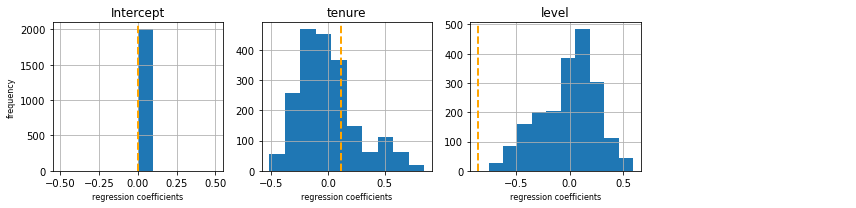

In [33]:
# Plot distribution of coefficients (permutation test)
mrqap_obj.plot()